## GLIMS region files download: Level 0 files

This script creates "Level 0" RGI files. These files are fetched directly from the GLIMS database, subsetted with a spatial bounding box around each region.

Level 0 files need to be updated to reflect new entries into the GLIMS database.

In [1]:
import geopandas as gpd
import shutil
from utils import mkdir
import numpy as np
import os

## RGI Region files 

In [2]:
# go down from rgi7_scripts/workflow/preprocessing
data_dir = '../../../rgi7_data/'

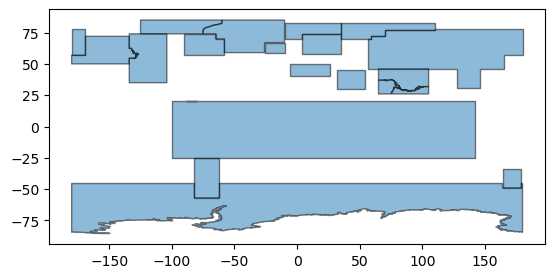

In [3]:
reg_file = os.path.join(data_dir, '00_rgi70_regions', '00_rgi70_O1Regions')
reg_f = gpd.read_file(reg_file)
reg_f.plot(alpha=0.5, edgecolor='k');

Region 10 has two boxes with glaciers in it:

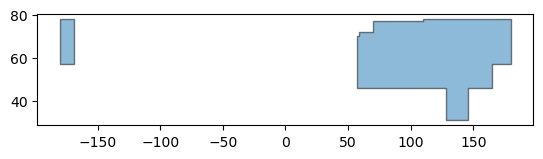

In [4]:
reg_f.loc[reg_f.o1region == '10'].plot(alpha=0.5, edgecolor='k');

## Download loop 

In [5]:
# If you want to (re-)download only selected regions
reg_f_sel = reg_f.loc[reg_f.o1region.isin(['05'])]  # , '19'
reg_f_sel

,o1region,full_name,long_code,geometry
4,05,Greenland Periphery,05_greenland_periphery,"POLYGON ((-75.00000 77.00000, -74.73000 77.510..."


### With login 

In [6]:
from glims_database_dump_wlogin import *

buffer = 0.5  # in degrees, buffer around the box
from_glims = mkdir(os.path.join(data_dir, 'l0_from_glims'))

for i, reg in reg_f_sel.iterrows():
    
    # Prepare bounds 
    x0, y0, x1, y1 = reg.geometry.bounds
    
    x0 = np.clip(x0 - buffer, -180., None)
    y0 = np.clip(y0 - buffer, -90., None)
    x1 = np.clip(x1 + buffer, None, 180.)
    y1 = np.clip(y1 + buffer, None, 90.)
    
    bounds = f' {x0:.2f},{y0:.2f},{x1:.2f},{y1:.2f}'
    print('')
    print('{}, {}. Bounds: {}'.format(reg.o1region, reg.full_name, bounds))
        
    # GLIMS request arguments
    p = setup_argument_parser()
    args = p.parse_args(['--mode', 'glims',
                         '--nunataks', 'GLIMS',  # We can't use RGI because it is buggy 
                         '--archive_type', 'tar',
                         '--download_type', 'extent',
                         '--clause', bounds,
                         '--netrc',
                         '--env', 'production'])
    
    urs_server = "urs.earthdata.nasa.gov"
    
    glims_servers = {
        "production": "www.glims.org/services",
        "blue": "blue.glims-services.apps.int.nsidc.org",
        "integration": "integration.glims.org/services",
        "qa": "qa.glims-services.apps.int.nsidc.org",
        "staging": "staging.glims-services.apps.int.nsidc.org",
    }
    server = glims_servers[args.env]

    if not args.noauth:
        # Get credentials from command-line or .netrc file
        credentials = get_credentials(args, urs_server)

        auth_session = get_authenticated_session(server, credentials[0], credentials[1])
        print("auth_session: ", auth_session)  # DEBUG

        if auth_session is None:
            print("Authentication failed.", file=sys.stderr)
            sys.exit(1)
    else:
        auth_session = get_noauth_session(server)

    filebasename = issue_order(server, auth_session, args)

    poll_readiness(
        server, auth_session, filebasename, args.protocol, period=2, tries=args.tries
    )  # returns when file is ready
    do_download(args, server, auth_session, filebasename)
    
    shutil.move(filebasename, os.path.join(from_glims, '{:02d}_RGI{:02d}.tgz'.format(i, int(reg['o1region']))))


05, Greenland Periphery. Bounds:  -75.50,58.50,-9.50,85.50
Authentication succeeded
NSIDC GLIMS could not authenticate with EDL
auth_session:  <requests.sessions.Session object at 0x7f55f6b9cbb0>
Issued order to downloadprepare service using requests.get.  URL is:
https://www.glims.org/services/downloadprepare?download_type=extent&clause=-75.50%2C58.50%2C-9.50%2C85.50&archive_type=tar&file_format=shapefile&data_model=GLIMS&glims_v_rgi=glims&rgidate=2000-09-01
Status code:  200
Try #   1:  False.  File name:  glims_download_31856.tgz
Try #   2:  False.  File name:  glims_download_31856.tgz
Try #   3:  False.  File name:  glims_download_31856.tgz
Try #   4:  False.  File name:  glims_download_31856.tgz
Try #   5:  False.  File name:  glims_download_31856.tgz
Try #   6:  False.  File name:  glims_download_31856.tgz
Try #   7:  False.  File name:  glims_download_31856.tgz
Try #   8:  False.  File name:  glims_download_31856.tgz
Try #   9:  False.  File name:  glims_download_31856.tgz
Try 

In [7]:
print('Done!')

Done!


### Without login 

In [ ]:
from glims_database_dump import *

servers = {
        'production': 'www.glims.org/services',
        'blue': 'blue.glims-services.apps.int.nsidc.org',
        'integration': 'integration.glims-services.apps.int.nsidc.org',
        'qa': 'qa.glims-services.apps.int.nsidc.org',
        'staging': 'staging.glims-services.apps.int.nsidc.org',
        }

buffer = 0.5  # in degrees, buffer around the box
from_glims = mkdir(os.path.join(data_dir, 'l0_from_glims'))

for i, reg in reg_f_sel.iterrows():
    
    # Prepare bounds 
    x0, y0, x1, y1 = reg.geometry.bounds
    
    x0 = np.clip(x0 - buffer, -180., None)
    y0 = np.clip(y0 - buffer, -90., None)
    x1 = np.clip(x1 + buffer, None, 180.)
    y1 = np.clip(y1 + buffer, None, 90.)
    
    bounds = f' {x0:.2f},{y0:.2f},{x1:.2f},{y1:.2f}'
    print('')
    print('{}, {}. Bounds: {}'.format(reg.RGI_CODE, reg.FULL_NAME, bounds))
        
    # GLIMS request arguments
    p = setup_argument_parser()
    args = p.parse_args(['--mode', 'glims',
                         '--nunataks', 'GLIMS',  # We can't use RGI because it is buggy 
                         '--archive_type', 'tar',
                         '--download_type', 'extent',
                         '--clause', bounds])

    server = servers[args.env]

    filebasename = issue_order(server, args)
    poll_readiness(server, filebasename, period=2, tries=args.tries, protocol=args.protocol)    # returns when file is ready
    do_download(server, filebasename, args)
    
    shutil.move(filebasename, os.path.join(from_glims, '{:02d}_RGI{:02d}.tgz'.format(i, int(reg['RGI_CODE']))))